In [10]:
import os
import time
import io

import bitstring

import numpy as np
import matplotlib.pyplot as plt
import cv2
import pandas as pd
from PIL import Image
from tqdm import tqdm
from collections import namedtuple

from list_char import JIS0208
from hiragana import basic_hiragana_char

In [11]:
dir = os.listdir('.')[5]

In [12]:
part_filepaths = [
    'ETL9B' + '\\ETL9B_1',
    'ETL9B' + '\\ETL9B_2',
    'ETL9B' + '\\ETL9B_3',
    'ETL9B' + '\\ETL9B_4',
    'ETL9B' + '\\ETL9B_5'
]

# Just to restart
for part_fpath in part_filepaths:
    if not os.path.exists(part_fpath):
        raise Exception(part_fpath, 'does not exist')

In [13]:
# Constant by specification
IMG_WIDTH = 64
IMG_HEIGHT = 63
sample_filepath = part_filepaths[3]
print(sample_filepath)

ETL9B\ETL9B_4


In [14]:
bitstring_unpack_str = ',' . join([
    'int:16',     # Serial Sheet Number - [0]
    'uint:16',    # JIS Kanji Code (JIS x 0208) - [1]
    '4*uint:8',   # JIS Typical Reading - [eg. 'AI.M'] - [2:6]
    'bytes:504',  # Image Data - [6]
    'pad:512'
])

In [15]:
infile = bitstring.ConstBitStream(filename=sample_filepath)

<h4> First Record of Each file is zero Padded Dummy </h4>

In [17]:
for i in range(0, 10):
    unpacked_data = infile.readlist(bitstring_unpack_str)
unpacked_data

[2404,
 9263,
 75,
 85,
 46,
 72,
 b'\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x02\x00\x00\x00\x00\x00\x00\x00\x07\x80\x00\x00\x00\x00\x00\x00\x0f\x80\x00\x00\x00\x00\x00\x00\x1f\x80\x00\x00\x00\x00\x00\x00?\x00\x00\x00\x00\x00\x00\x00~\x00\x00\x00\x00\x00\x00\x00\xfc\x00\x00\x00\x00\x00\x00\x01\xf8\x00\x00\x00\x00\x00\x00\x03\xf0\x00\x00\x00\x00\x00\x00\x07\xc0\x00\x00\x00\x00\x00\x00\x0f\x80\x00\x00\x00\x00\x00\x00\x1f\x80\x00\x00\x00\x00\x00\x00>\x00\x00\x00\x00\x00\x00\x00|\x00\x00\x00\x00\x00\x00\x01\xf8\x00\x00\x00\x00\x00\x00\x07\xf0\x00\x00\x00\x00\x00\x00\x07\xe0\x00\x00\x00\x00\x00\x00\x03\xe0\x00\x00\x00\x00\x00\x00\x03\xe0\x00\x00\x00\x00\x00\x00\x01\xf0\x00\x00\x00\x00\x00\x00\x00\xf0\x00\x00\x00\x00\x00\x00\x00x\x

<class 'int'> sheet_number: 2404
<class 'int'> jis_char_code: 9263
unicode_char: く
<class 'str'> jis_reading: 'KU.H'


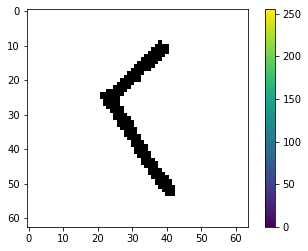

In [26]:
# Type int - Serial Number Sheet
sheet_num = unpacked_data[0]

# type: binary - JIST Kanji Code (JIS x 0208)
jis_char_code = unpacked_data[1]

if jis_char_code in JIS0208:
    unicode_char = JIS0208[jis_char_code]
else:
    unicode_char = 'null_' + repr(jis_char_code)
    
# type: ASCII - JIS Typical Reading (eg. 'AI.M')
jis_reading = unpacked_data[2:6]
jis_reading = ''.join(list(map(chr, jis_reading)))

# type: bytes
raw_image_data = unpacked_data[6]

print(type(sheet_num), 'sheet_number:', sheet_num)
print(type(jis_char_code), 'jis_char_code:', jis_char_code)
print('unicode_char:', unicode_char)
print(type(jis_reading), 'jis_reading:', repr(jis_reading))

pil_image = np.asarray(Image.frombytes('1', (IMG_WIDTH, IMG_HEIGHT), raw_image_data, 'raw')).astype('uint8')
img = cv2.cvtColor(pil_image, cv2.COLOR_GRAY2RGB) * 255

for idx1, first in enumerate(img):
    for idx2, second in enumerate(first):
        for idx3, third in enumerate(second):
            if img[idx1][idx2][idx3] == 0:
                img[idx1][idx2][idx3] = 255
            else:
                img[idx1][idx2][idx3] = 0

plt.imshow(img)
plt.colorbar()

In [11]:
metadata_fields = [
    'char',
    'dataset_source',
    'width',
    'height',
    'seek_start',
    'seek_end',
    'sheet_number',
    'jis_reading',
]

Record = namedtuple('Record', ' '.join(metadata_fields))

In [27]:
save_dir = 'ETL9B\\IMG_WHITE'
idx = 0
record_metadata_list = []

if not os.path.exists(save_dir):
    os.makedirs(save_dir)

png_image_packed_fpath = os.path.join(save_dir, 'images.bin')

with open(png_image_packed_fpath, mode='wb') as outfile:
    # I decided to use a local variable to track the current file seeking position
    # instead of call outfile.tell() every time we need to know the current seeking position.
    # I think this is fine in our case because we only write/append to the output file.
    cur_file_pos = 0

    pbar = tqdm(part_filepaths)
    for part_fpath in pbar:
        pbar.set_description(part_fpath)

        infile = bitstring.ConstBitStream(filename=part_fpath)
        # skip the first record in each file
        infile.readlist(bitstring_unpack_str)

        # throttle tqdm
        tqdm_idx = 0
        while True:
            tqdm_idx += 1

            try:
                unpacked_data = infile.readlist(bitstring_unpack_str)
            except:
                break

            # type: int - Serial Sheet Number
            sheet_number = unpacked_data[0]

            # type: binary - JIS Kanji Code (JIS X 0208)
            jis_char_code = unpacked_data[1]

            if jis_char_code in JIS0208:
                unicode_char = JIS0208[jis_char_code]
            else:
                unicode_char = 'null_' + repr(jis_char_code)

            # type: ASCII - JIS Typical Reading (e.g. 'AI.M')
            jis_reading = unpacked_data[2:6]
            jis_reading = ''.join(list(map(chr, jis_reading)))
            
            # type: bytes
            raw_image_data = unpacked_data[6]
            pil_image = np.array(Image.frombytes('1', (IMG_WIDTH, IMG_HEIGHT), raw_image_data, 'raw'))

        
            # Save Image
            for hiragana in basic_hiragana_char:
                if unicode_char == hiragana.split("-")[0]:
                    filename = str(idx) + "_" + hiragana + "_hira" + ".png"
                    filename = os.path.join(save_dir, filename)
                    
                    pil_image = np.asarray(Image.frombytes('1', (IMG_WIDTH, IMG_HEIGHT), raw_image_data, 'raw')).astype('uint8')
                    img = cv2.cvtColor(pil_image, cv2.COLOR_GRAY2RGB) * 255
                    
                    avg_color_per_row = np.average(img, axis=0)
                    avg_color = np.average(avg_color_per_row, axis=0)

                    for idx1, first_iter in enumerate(img):
                        for idx2, second_iter in enumerate(first_iter):
                            for idx3, third_iter in enumerate(second_iter):
                                if third_iter <= np.round(avg_color[idx3]):
                                    img[idx1][idx2][idx3] = 255
                                else:
                                    img[idx1][idx2][idx3] = 0
                    
                    cv2.imwrite(filename, img)
                    #pil_image.save(filename)
                    idx = idx + 1
                
            if (tqdm_idx % 1000) == 0:
                pbar.set_description(f'{part_fpath} - {jis_reading} - {unicode_char}')

ETL9B\ETL9B_5 - BETS - 瞥: 100%|████████████████████████████████████████████████████████| 5/5 [15:01<00:00, 180.23s/it]]


In [ ]:
record_metadata_fpath = os.path.join(save_dir, 'metadata-9B.tsv')

with open(record_metadata_fpath, mode='wb') as outfile:
    # write the header
    outfile.write(('\t'.join(metadata_fields) + '\n').encode('utf-8'))

    for row in tqdm(record_metadata_list):
        s_arr = []
        for field in row:
            if type(field) is str:
                s_arr.append(field)
            else:
                s_arr.append(repr(field))

        outfile.write(('\t'.join(s_arr) + '\n').encode('utf-8'))